# **Data Preparation**

In [3]:
import json
with open('result.json') as f:
  cocodata = json.load(f)

In [4]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
  # Remove the image directory from the file name
  image['file_name'] = image['file_name'].split('/')[-1]
  image['image_id'] = image['id']
  # Extend the image dict with bounding boxes and class labels
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
  # Iterate through the annotations (bounding boxes and labels)
  for annot in cocodata['annotations']:
    # Check if the annotation matches the image
    if annot['image_id'] == image['id']:
      # Add the annotation
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list
  huggingdata.append(image)

In [5]:
with open("metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

In [7]:
import shutil


original = '/content/metadata.jsonl'
target1 = '/content/imagefolder/train/metadata.jsonl'
target2 = '/content/imagefolder/test/metadata.jsonl'

shutil.copyfile(original, target1)
shutil.copyfile(original, target2)

'/content/imagefolder/test/metadata.jsonl'

In [9]:
# !pip install datasets

In [10]:
from datasets import load_dataset

candy_data = load_dataset('imagefolder', data_dir="/content/imagefolder") # Assumes the data is stored in a folder called "data".

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-2a234c72e42b727c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

# **Model Training**

In [12]:
# !pip install -q datasets transformers evaluate timm albumentations

In [13]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [14]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [15]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [16]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [17]:
candy_data['train'] = candy_data['train'].with_transform(transform_aug_ann)

In [18]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [19]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# !pip install transformers[torch]
# !pip install accelerate -U

In [21]:
# !pip install transformers -U

In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trained_model",
    per_device_train_batch_size=8,
    num_train_epochs=500,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [23]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data["train"],
    tokenizer=image_processor,
)

trainer.train()

/content/trained_model is already a clone of https://huggingface.co/AlexLien/trained_model. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,1.478300
100,0.983900
150,0.679900
200,0.512600
250,0.441000
300,0.379600
350,0.328600
400,0.304500
450,0.284400
500,0.288900


TrainOutput(global_step=1000, training_loss=0.39389689445495607, metrics={'train_runtime': 942.1513, 'train_samples_per_second': 5.838, 'train_steps_per_second': 1.061, 'total_flos': 2.62852235712e+18, 'train_loss': 0.39389689445495607, 'epoch': 500.0})

# **Save Model**

In [24]:
trainer.save_model('candy_detector')

# **candy_counter(image) Method**

In [45]:
from PIL import Image, ImageDraw

image = Image.open(r"/content/imagefolder/train/4cc0ea39-cd_10.jpg")

image_processor = AutoImageProcessor.from_pretrained("/content/candy_detector")
model = AutoModelForObjectDetection.from_pretrained("/content/candy_detector")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Grey_star with confidence 0.987 at location [137.83, 51.22, 161.38, 75.95]
Detected Unicorn_whole with confidence 0.896 at location [111.43, 11.18, 151.99, 40.44]
Detected Unicorn_head with confidence 0.897 at location [243.6, 101.01, 274.51, 139.62]
Detected Unicorn_head with confidence 0.896 at location [56.84, 29.26, 91.02, 54.83]
Detected Unicorn_head with confidence 0.857 at location [191.87, 141.52, 227.71, 172.8]
Detected Insect with confidence 0.973 at location [200.16, 87.24, 237.04, 114.03]
Detected Owl with confidence 0.907 at location [234.21, 47.98, 266.62, 79.61]
Detected Unicorn_whole with confidence 0.937 at location [101.2, 115.62, 152.1, 144.74]
Detected Cat with confidence 0.608 at location [100.63, 65.56, 128.65, 99.07]
Detected Unicorn_whole with confidence 0.979 at location [172.68, 7.41, 205.48, 52.34]
Detected Grey_star with confidence 0.975 at location [69.5, 182.63, 97.79, 209.66]
Detected Grey_star with confidence 0.955 at location [135.04, 79.26, 15

In [42]:
def candy_counter(image):
  detection = {'Moon': 0,
               'Insect': 0,
               'Black_star': 0,
               'Grey_star': 0,
               'Unicorn_whole': 0,
               'Unicorn_head': 0,
               'Owl': 0,
               'Cat': 0}

  with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    detection[model.config.id2label[label.item()]] += 1

  return detection

In [46]:
candy_counter(image)

{'Moon': 1,
 'Insect': 2,
 'Black_star': 1,
 'Grey_star': 5,
 'Unicorn_whole': 3,
 'Unicorn_head': 4,
 'Owl': 1,
 'Cat': 1}

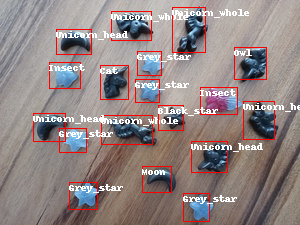

In [47]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image